# Setup

In [4]:
import sys 
sys.path.append('../')
from IPython.display import display
import pandas as pd 
import pickle
import os 
import re 
import pickle

from utils.env import EvoD4jEnv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

def convert_docker_to_local_path(path):
    path  = path.replace("/root/workspace","/home/coinse/Workspace/hslee_workspace/autooracle/workspace")
    return path

def convert_to_prompt_path(chat_reply_file_path):
    if "chat_reply_mut" in chat_reply_file_path:
        chat_reply_file_path = chat_reply_file_path.replace("chat_reply_mut", "prompt")
    else:
        chat_reply_file_path = chat_reply_file_path.replace("chat_reply", "prompt")
    prompt_path = chat_reply_file_path.split('/')
    del prompt_path[-2]
    if prompt_path[-1].endswith("reply.txt"):
        prompt_path[-1] = prompt_path[-1].replace("reply.txt","query.txt")
    prompt_path = '/'.join(prompt_path)
    return prompt_path

def extract_label(path):
    # with open(path, 'r') as file:
    #     file_content = file.read()
    # lines = file_content.split('\n')
    # for line in reversed(lines):
    #     if 'undecidable' in line.lower():
    #         return 'undecidable'
    #     elif 'incorrect' in line.lower():
    #         return 'incorrect'
    #     elif 'correct' in line.lower():
    #         return 'correct'
    #     else:
    #         pass
    with open(path, 'r') as file:
        file_content = file.read()
    lines = file_content.split('\n')
    llm_answer = lines[-1]
    if 'undecidable' in llm_answer.lower():
        return 'undecidable'
    elif 'incorrect' in llm_answer.lower():
        return 'incorrect'
    elif 'correct' in llm_answer.lower():
        return 'correct'
    else:
        print("No label in this:",path,"\nNeed to be deleted and re_run")
        with open('./to_delete.txt', 'a') as w:
            w.write(f'{path}\n')
    # If no label is found, return None
    return "None"

def get_docmumet_length(prompt_path):
    with open(prompt_path,'r') as f:
        prompt = f.readlines()
    words = []
    isdocument=False
    for line in prompt:
        if line.find("signature:") != -1:
            isdocument = True
            continue
        if isdocument:
            if line.find("```") != -1:
                isdocument= False
                continue
            words.extend(line.strip().split())
        if not isdocument and len(words) > 0:
            break
    return len(words)

def process_test_info(file_name, chat_reply_file_path):
    test_infos = file_name.split('_')
    test_class = test_infos[0]
    test_no = test_infos[1]
    oracle_type = test_infos[2]
    document_length = get_docmumet_length(convert_to_prompt_path(chat_reply_file_path))
    return test_class, test_no, oracle_type, document_length

def get_idx_chat_reply_result(project, version, idx, ts_id, prompt_no, example_num):
    env = EvoD4jEnv(project, version, idx, ts_id)
    chat_reply_org_root_path = convert_docker_to_local_path(os.path.join(env.evosuite_chat_reply_dir, f'prompt{prompt_no}', f'example{example_num}'))
    chat_reply_trs_root_path = convert_docker_to_local_path(os.path.join(env.evosuite_chat_reply_transform_dir, f'prompt{prompt_no}', f'example{example_num}'))

    idx_test_info = {} # key: test_no, value : [(result1 info), result2, result3, result4, result5]
    idx_test_result = {} # 
    for root_path in [chat_reply_org_root_path, chat_reply_trs_root_path]:
        for try_no in range(1, 6):
            chat_reply_path = os.path.join(root_path, f'try{try_no}')
            for file_name in os.listdir(chat_reply_path):
                chat_reply_file_path = os.path.join(chat_reply_path, file_name)
                label = extract_label(chat_reply_file_path)
                
                test_class, test_no, oracle_type, document_length = process_test_info(file_name, chat_reply_file_path)
                idx_test_info.setdefault(test_no, [test_class, oracle_type, document_length])
                idx_test_result.setdefault(test_no, []).append(label)
    # a = list(idx_test_result.values())
    # for i in a:
    #     print(len(i))
    return idx_test_info, idx_test_result


def process_test_info_df(project, info_dict, result_dict, sample_num, gt_label):
    df_rows = []
    for idx, tests_dict in info_dict.items():
        for test_no, info_list in tests_dict.items():
            df_rows.append({
                'project': project,
                'version': '1',
                'idx': idx,
                'ts_id': 'newTS_300',
                'test_no': test_no,
                'test_class': info_list[0],
                'type': info_list[1],
                'document_length': info_list[2],
                'ground_truth': gt_label,
                'attempt_org': result_dict[idx][test_no][:sample_num],
                'attempt_trs': result_dict[idx][test_no][5: 5 + sample_num]
            })
    return pd.DataFrame(df_rows)

def score_org(attempt_list):
    score = 0
    for reply in attempt_list:
        if reply == "correct":
            score += 1
        elif reply == "incorrect":
            score -= 1
        elif reply == "undecidable":
            score += 0
        else: 
            score += 0
    return score

def score_trs(attempt_list):
    score = 0
    for reply in attempt_list:
        if reply == "correct":
            score -= 1
        elif reply == "incorrect":
            score += 1
        elif reply == "undecidable":
            score += 0
        else: 
            score += 0
    return score

def get_fail_pass_df(project, version, ts_id, prompt_no, example_no, sample_num):
    fail_info, fail_result, pass_info, pass_result = all_chat_reply_result(project, version, ts_id, prompt_no, example_no)
    # Create DataFrames for fail and pass results
    fail_df = process_test_info_df(project, fail_info, fail_result, sample_num, "incorrect")
    pass_df = process_test_info_df(project, pass_info, pass_result, sample_num, "correct")

    fail_df["score_org"] = fail_df["attempt_org"].apply(score_org)
    fail_df["score_trs"] = fail_df["attempt_trs"].apply(score_trs)
    fail_df["score"] = fail_df["score_org"] + fail_df["score_trs"]
    #fail_df["score"] = 0 + fail_df["score_trs"]

    pass_df["score_org"] = pass_df["attempt_org"].apply(score_org)
    pass_df["score_trs"] = pass_df["attempt_trs"].apply(score_trs)
    pass_df["score"] = pass_df["score_org"] + pass_df["score_trs"]
    #pass_df["score"] = 0 + pass_df["score_trs"]
    return fail_df, pass_df

def all_chat_reply_result(project, version, ts_id, prompt_no, example_no):
    with open(f'/home/coinse/Workspace/hslee_workspace/autooracle/workspace/src/select_dataset/{project}_tests_new.pkl',"rb") as fw:
        dataset_info = pickle.load(fw)
    all_fail_idx_test_info = {}
    all_fail_idx_test_result = {}
    all_pass_idx_test_info = {}
    all_pass_idx_test_result = {}
    a = 0
    b = 0
    for idx, [fail_tests, pass_tests] in dataset_info.items():
        a += len(fail_tests)
        b += len(pass_tests)
        idx_test_info, idx_test_result = get_idx_chat_reply_result(project, version, str(idx), ts_id, prompt_no, example_no)
        
        fail_test_info = {test_no: info for test_no, info in idx_test_info.items() if test_no in fail_tests}
        fail_test_result = {test_no: label for test_no, label in idx_test_result.items() if test_no in fail_tests}
        for key, value in fail_test_result.items():
            if len(value) != 10 or "None" in value:
                print(f"There are test which needs to be complemented, check ../query/{project}_complement.txt")
                print(f'{idx} {key}')
                with open(f'../query/{project}_complement.txt','a') as f:
                    f.write(f'{idx} {key}\n')
            
        pass_test_info = {test_no: info for test_no, info in idx_test_info.items() if test_no in pass_tests}
        pass_test_result = {test_no: label for test_no, label in idx_test_result.items() if test_no in pass_tests}
        for key, value in pass_test_result.items():
            if len(value) != 10 or "None" in value:
                print(f"There are test which needs to be complemented, check ../query/{project}_complement.txt")
                print(f'{idx} {key}')
                with open(f'../query/{project}_complement.txt','a') as f:
                     f.write(f'{idx} {key}\n')
        all_fail_idx_test_info[idx] = fail_test_info
        all_fail_idx_test_result[idx] = fail_test_result
        all_pass_idx_test_info[idx] = pass_test_info
        all_pass_idx_test_result[idx] = pass_test_result
    print(a,b)
    return all_fail_idx_test_info, all_fail_idx_test_result, all_pass_idx_test_info, all_pass_idx_test_result


# Visualization

In [53]:
import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
import seaborn as sns
import csv
import numpy as np

# def plot_countplot(ax, data, x, color):
#     a = sns.countplot(data=data, x=x, color=color)
#     plot_sum = 0
#     for p in a.patches:
#         height = p.get_height()
#         plot_sum += height
#     for p in a.patches:
#         height = p.get_height()
#         ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
#         #ax.annotate(f'{height/plot_sum * 100:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
#     ax.set_xlabel("Predict", fontsize=10)
#     ax.set_ylabel("number of test", fontsize=10)

# def count_plot(fail_df, pass_df):
#     plt.figure(figsize=(12, 8))

#     # Original Plots
#     plt.subplot(2, 3, 1)
#     plt.title("Original_fail", fontdict={'fontsize': 10})
#     plot_countplot(plt.gca(), fail_df, "score_org", '#4BC6CC')

#     plt.subplot(2, 3, 4)
#     plt.title("Original_pass", fontdict={'fontsize': 10})
#     plot_countplot(plt.gca(), pass_df, "score_org", '#4BC6CC')

#     # Transformed Plots
#     plt.subplot(2, 3, 2)
#     plt.title("Transformed_fail", fontdict={'fontsize': 10})
#     plot_countplot(plt.gca(), fail_df, "score_trs", '#FF6E3E')

#     plt.subplot(2, 3, 5)
#     plt.title("Transformed_pass", fontdict={'fontsize': 10})
#     plot_countplot(plt.gca(), pass_df, "score_trs", '#FF6E3E')
#     # Sum Plots
#     fail_df["score"] = fail_df["score_org"] + fail_df["score_trs"]
#     plt.subplot(2, 3, 3)
#     plt.title("Sum[Incorrect Oracle]", fontdict={'fontsize': 10})
#     plot_countplot(plt.gca(), fail_df, "score", 'dodgerblue')

#     pass_df["score"] = pass_df["score_org"] + pass_df["score_trs"]
#     plt.subplot(2, 3, 6)
#     plt.title("Sum[Correct Oracle]", fontdict={'fontsize': 10})
#     plot_countplot(plt.gca(), pass_df, "score", 'dodgerblue')

#     plt.tight_layout()
#     plt.show()

# def hist_plot(fail_df, pass_df):
#     fail_df["ground_truth"] = "incorrect"
#     pass_df["ground_truth"] = "correct"
#     pred_df = pd.concat([fail_df, pass_df])
#     sns.histplot(data=pred_df, x="score", hue="ground_truth", multiple="dodge")
#     plt.yscale("log")

# def accumulate_incorrect_ratio_graph(pred_df):
#     prediction_columns = ["score", "score_org", "score_trs"]
#     plt.figure(figsize=(13, 5))
#     for i, col in enumerate(prediction_columns):
#         # plt.subplot(1, len(prediction_columns), i+1)
#         thresholds = range(pred_df[col].min(), pred_df[col].max() +1)
#         incorrect_ratio = [(pred_df[pred_df[col] <= score].ground_truth == "incorrect").mean() for score in thresholds]
#         scores = [ 2 * th /(max(thresholds) - min(thresholds)) for th in thresholds]
#         plt.plot(scores, incorrect_ratio, marker=".", label=col)

#     plt.hlines((pred_df.ground_truth == "incorrect").mean(), min(scores), max(scores), color="red", label="% incorrect tests")
#     plt.xlabel("th")
#     plt.ylabel("% incorrect tests with score <= th")
#     plt.legend()
#     plt.ylim((-0.05, 1.05))
#     plt.show()
    
def incorrect_ratio_all(fail_df, pass_df, pred_df, save_name, figsize, markersize):
    prediction_columns = ["score", "score_org", "score_trs"]
    plot_data = []
    
    for col in prediction_columns:
        fail_counts = fail_df[col].value_counts()
        pass_counts = pass_df[col].value_counts()
        total_counts = fail_counts.add(pass_counts, fill_value=0)
        failing_ratio = fail_counts / total_counts
        
        if col == 'score':
            score_range = 10
        else:
            score_range = 5
        #score_range = max_score - min_score
        
        for score, ratio in failing_ratio.items():
            scaled_score = (score / score_range)
            plot_data.append({
                'Scaled Score': scaled_score ,
                'Failing Ratio': ratio,
                'Prediction Column': col,
            })
    
    plot_df = pd.DataFrame(plot_data)

    color_palette = {"score": "xkcd:royal blue", "score_org": "tab:orange", "score_trs": "tab:green"}

    # Plotting
    plt.figure(figsize=figsize)

    # Grouping the DataFrame by 'Prediction Column' to plot each with a different color
    for col_name, df_group in plot_df.groupby('Prediction Column'):
        if col_name == "score":
            label_name = "Metamorphic prompt"
        elif col_name == "score_org":
            label_name = "Orginal prompt"
        elif col_name == "score_trs":
            label_name = "Transformed prompt"
        plt.plot(df_group['Scaled Score'], df_group['Failing Ratio'], marker="o", makersize=markersize, linestyle='-', color=color_palette[col_name], label=label_name)
        pearson_corr, pearson_p_value = pearsonr(df_group['Scaled Score'], df_group['Failing Ratio'])
        spearman_corr, spearman_p_value = spearmanr(df_group['Scaled Score'], df_group['Failing Ratio'])

        print(f"{col_name} - Pearson's correlation: {pearson_corr}, Pearson's pvalue: {pearson_p_value}, Spearman's correlation: {spearman_corr}, Spearman's pvalue: {spearman_p_value}")

    # This sets the x-axis limits to encompass all your data points
    x_lims = plt.xlim()

    # Assuming pred_df is a DataFrame with a column 'ground_truth' indicating if a test is incorrect
    percentage_incorrect_tests = (pred_df['ground_truth'] == "incorrect").mean()
    plt.hlines(percentage_incorrect_tests, x_lims[0], x_lims[1], color="red", label="Baseline", linestyles="dotted")

    plt.xlabel("Normalized Score")
    plt.ylabel("% of test w/incorrect oracle")
    plt.legend(fontsize=8, loc="upper right")
    plt.tight_layout()
    plt.savefig(save_name)
    # if not os.path.exists(f'{project}_{prompt_no}_row.csv'):
    #     with open(f'{project}_{prompt_no}_row.csv',"w") as f:
    #         for _, row in plot_df.iterrows():
    #             f.write(f"Column: {row['Prediction Column']}, Scaled Score: {row['Scaled Score']:.2f}, Failing Ratio: {row['Failing Ratio']:.2f}, Counts: {row['Text']}\n")

def incorrect_ratio_metamorphic(fail_df, pass_df, pred_df,save_name): 
    plot_data = []
    
    fail_counts = fail_df["score"].value_counts()
    pass_counts = pass_df["score"].value_counts()
    total_counts = fail_counts.add(pass_counts, fill_value=0)
    failing_ratio = fail_counts / total_counts
    
    
    for score, ratio in failing_ratio.items():
        scaled_score = (score / 10)
        plot_data.append({
            'Scaled Score': scaled_score ,
            'Failing Ratio': ratio,
            'Prediction Column': "score",
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plotting
    plt.figure(figsize=(6, 5))
    
    # Line plot for Failing Ratio with marker 'o'
    plt.plot(plot_df['Scaled Score'], plot_df['Failing Ratio'], marker="o", linestyle='-', color='xkcd:royal blue', label="Metamorphic prompt")
    
    # Adding the stacked bars for Fail Ratio and Pass Ratio
    
    # Baseline for percentage of incorrect tests
    percentage_incorrect_tests = (pred_df.ground_truth == "incorrect").mean()
    plt.hlines(percentage_incorrect_tests, plot_df['Scaled Score'].min(), plot_df['Scaled Score'].max(), color="red", label="Baseline", linestyles="dotted")
    
    plt.xlabel("Normalized Score", fontsize='large')
    plt.legend(fontsize='small')  # Setting the legend font size to 'large'
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import colorsys

# def adjust_lightness(color, amount):
#     """
#     Adjust the lightness of a given color.
#     :param color: Base color in hex or named.
#     :param amount: Factor to adjust by. >1 to lighten, <1 to darken.
#     :return: Adjusted color in hex format.
#     """
#     import matplotlib.colors as mc
#     try:
#         c = mc.to_rgb(color)
#         c = colorsys.rgb_to_hls(*c)
#         c = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
#         return mc.to_hex(c)
#     except:
#         return color


def incorrect_ratio_self_consistency(df_s,save_path, figsize, markersize):
    plt.figure(figsize=figsize)  # Initialize the figure

    #color_palette = {4: "midnightblue", 3: "mediumblue", 2: "royalblue", 1: "cornflowerblue", 0: "lightsteelblue"}
    color_palette = {4: "xkcd:royal blue", 3: "xkcd:mid blue", 2: "xkcd:azure", 1: "xkcd:sky blue", 0: "xkcd:powder blue"}

    for i, df in enumerate(df_s):
        # Calculating fail and pass counts
        fail_df = df[df.ground_truth == "incorrect"]
        pass_df = df[df.ground_truth == "correct"]
        
        fail_counts = fail_df["score"].value_counts().sort_index()
        pass_counts = pass_df["score"].value_counts().sort_index()
        total_counts = fail_counts.add(pass_counts, fill_value=0)
        
        failing_ratio = fail_counts / total_counts
        
        # Scaled score
        scaled_scores = fail_counts.index / ((10-2*i))
        # Plotting failing ratio
        plt.plot(scaled_scores, failing_ratio, marker="o", linestyle='-',markersize = markersize,  color=color_palette[4-i], label=f"n={5-i}")
       
    # Baseline for percentage of incorrect tests
    plt.hlines(0.5, scaled_scores.min() - 0.1, scaled_scores.max() + 0.1, color="red", label="Baseline", linestyles="dotted")
    
    plt.xlabel("Normalized Score")
    plt.ylabel("% of test w/incorrect oracle")
    plt.legend(fontsize=8, loc="upper right")  # Adjust legend font size for readability
    plt.tight_layout()
    plt.savefig(save_path)

def stacked_bar_metamorphic(fail_df, pass_df):
    plot_data = []
    
    fail_counts = fail_df["score"].value_counts()
    pass_counts = pass_df["score"].value_counts()
    total_counts = fail_counts.add(pass_counts, fill_value=0)
    
    for score in total_counts.index.sort_values():
        scaled_score = (score / 10)
        fail_count = fail_counts.get(score, 0)
        pass_count = pass_counts.get(score, 0)
        plot_data.append({
            'Scaled Score': scaled_score,
            'Fail Count': fail_count,
            'Pass Count': pass_count,
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plotting
    plt.figure(figsize=(8, 4.8))
    
    bar_width = 0.03  # Adjust the width as needed
    print(plot_df['Pass Count'])
    print(plot_df['Fail Count'])
    plt.bar(plot_df['Scaled Score'] - bar_width/2, plot_df['Pass Count'], width=bar_width, label='Test w/ Correct Oracle', color='lightgreen')
    plt.bar(plot_df['Scaled Score'] - bar_width/2, plot_df['Fail Count'], bottom=plot_df['Pass Count'], width=bar_width, label='Test w/ Incorrect Oracle', color='salmon')
    plt.xlabel("Normalized Score", fontsize='large')
    plt.legend(fontsize='large')  # Setting the legend font size to 'large'
    plt.tight_layout()
    plt.savefig('./fig/stack_bar_metamorphic.pdf')

def stacked_bar_org(fail_df, pass_df):
    plot_data = []
    
    fail_counts = fail_df["score_org"].value_counts()
    pass_counts = pass_df["score_org"].value_counts()
    total_counts = fail_counts.add(pass_counts, fill_value=0)
    
    for score in total_counts.index.sort_values():
        scaled_score = (score / 5)
        fail_count = fail_counts.get(score, 0)
        pass_count = pass_counts.get(score, 0)
        plot_data.append({
            'Scaled Score': scaled_score,
            'Fail Count': fail_count,
            'Pass Count': pass_count,
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plotting
    plt.figure(figsize=(8, 4.8))
    
    bar_width = 0.03  # Adjust the width as needed

    plt.bar(plot_df['Scaled Score'] - bar_width/2, plot_df['Pass Count'], width=bar_width, label='Test w/ Correct Oracle', color='lightgreen')
    plt.bar(plot_df['Scaled Score'] - bar_width/2, plot_df['Fail Count'], bottom=plot_df['Pass Count'], width=bar_width, label='Test w/ Incorrect Oracle', color='salmon')
    plt.xlabel("Normalized Score", fontsize='large')
    plt.legend(fontsize='large')  # Setting the legend font size to 'large'
    plt.tight_layout()
    plt.savefig('./fig/stack_bar_org.pdf')


def incorrect_ratio_bar_graph(fail_df, pass_df, pred_df):
    prediction_columns = ["score", "score_org", "score_trs"]
    plot_data = []
    
    for col in prediction_columns:
        fail_counts = fail_df[col].value_counts()
        pass_counts = pass_df[col].value_counts()
        total_counts = fail_counts.add(pass_counts, fill_value=0)
        failing_ratio = fail_counts / total_counts
        min_score = pred_df[col].min()
        max_score = pred_df[col].max()
        score_range = max_score - min_score
        
        for score, ratio in failing_ratio.items():
            scaled_score = (2 * score / score_range)
            plot_data.append({
                'Scaled Score': scaled_score ,
                'Failing Ratio': ratio,
                'Prediction Column': col
            })
    
    plot_df = pd.DataFrame(plot_data)

    color_palette = {"score": "xkcd:royal blue'", "score_org": "tab:orange", "score_trs": "tab:green"}

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Scaled Score', y='Failing Ratio', hue='Prediction Column', data=plot_df, palette=color_palette)
    plt.grid()
    x_lims = plt.xlim()  # Get current x-axis limits
    plt.hlines((pred_df.ground_truth == "incorrect").mean(), x_lims[0], x_lims[1], color="red", label="% incorrect tests", linestyles="dotted")
    plt.xlabel("Scaled Score")
    plt.ylabel("Failing Ratio")
    plt.title("Failing Ratio by Scaled Score for Each Prediction Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

# def precision_heatmap(pred_df):
#     rat_rows_precision = []
#     for org_score in range(-5, 6):
#         for trs_score in range(-5, 6):
#             # True Positives (TP): Ground truth is "incorrect" and predicted as "incorrect"
#             TP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "incorrect")).sum()
#             # False Positives (FP): Ground truth is "correct" but predicted as "incorrect"
#             FP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "correct")).sum()
#             # Calculate precision
#             precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#             rat_rows_precision.append((org_score, trs_score, precision))

#     # Create precision dataframe and heatmap
#     plt.figure(figsize=(10, 10))
#     rat_df_precision = pd.DataFrame(data=rat_rows_precision, columns=["org_th", "trs_th", "precision"]).pivot("org_th", "trs_th", "precision")
#     sns.heatmap(rat_df_precision, annot=True, fmt=".2f", cmap="Reds")
    
#     plt.xlabel("Threshold for Transformation Score")
#     plt.ylabel("Threshold for Original Score")
#     plt.title("Precision Heatmap")
#     plt.show()

def document_length_graph(pred_df):
    score_doclen = []
    for score in range(0, 11):
        document_length = pred_df[(pred_df.score == score) | (pred_df.score == -score)].document_length.mean()
        score_doclen.append((score, document_length))
    score_doclen_df = pd.DataFrame(data=score_doclen, columns=["score","doc_leng"])
    plt.plot(score_doclen_df["score"],score_doclen_df["doc_leng"], marker=".")
    
    print("doc_pearsonr:",pearsonr(score_doclen_df["doc_leng"], score_doclen_df["score"]))
    sns.scatterplot(data= pred_df, x = "score", y = "document_length")
    plt.xlabel("|score|")
    plt.ylabel("Document Length")
    plt.legend()
    plt.title("Correlation btw score and Doc_length")

# def boxplot_pearsonr(pred_df):
#     plt.figure(figsize=(5, 5))
#     sns.set_theme(style='whitegrid')
#     pred_df["is_correct"] = pred_df["ground_truth"] == "correct"
#     sns.boxplot(data=pred_df, x="ground_truth", y="score")
#     print("pearsonr:",pearsonr(pred_df["is_correct"], pred_df["score"])) # point - biserial correlation coefficient

# def distplot(pred_df):
#     plt.figure(figsize=(5, 5))
#     sns.displot(data=pred_df, hue="ground_truth", x="score", kde=True, multiple='dodge')

def roc_auc(pred_df):
    #plt.figure(figsize=(5, 5))
    pred_df.loc[pred_df["ground_truth"]=="incorrect",["label"]] = 1
    pred_df.loc[pred_df["ground_truth"]=="correct",["label"]] = 0
    suspiciousness = -(pred_df.score - pred_df.score.min())/(pred_df.score.max() - pred_df.score.min()) # 0 ~ 1
    fprs, tprs, thresholds = roc_curve(pred_df.label.astype(bool), suspiciousness)
    print('roc_acu_score:', "{:.4f}".format(roc_auc_score(pred_df.label.astype(bool), suspiciousness)))
    #plt.plot(fprs, tprs, label = f'prompt')
    #plt.xlabel('FPR')
    #plt.ylabel('TPR')
    #plt.title("ROC Curve")
    #plt.legend()
import matplotlib.pyplot as plt
import pandas as pd

def combined_metamorphic_analysis(fail_df, pass_df, pred_df,save_path):
    # Initial data preparation
    fail_counts = fail_df["score"].value_counts()
    pass_counts = pass_df["score"].value_counts()
    total_counts = fail_counts.add(pass_counts, fill_value=0)
    failing_ratio = fail_counts / total_counts
    
    plot_data_ratio = []
    plot_data_counts = []
    
    # Prepare data for failing ratio
    for score, ratio in failing_ratio.items():
        scaled_score = (score / 10)
        plot_data_ratio.append({
            'Scaled Score': scaled_score,
            'Failing Ratio': ratio
        })
        
    # Prepare data for pass and fail counts
    for score in total_counts.index.sort_values():
        scaled_score = (score / 10)
        fail_count = fail_counts.get(score, 0)
        pass_count = pass_counts.get(score, 0)
        plot_data_counts.append({
            'Scaled Score': scaled_score,
            'Fail Count': fail_count,
            'Pass Count': pass_count,
        })
    
    plot_df_ratio = pd.DataFrame(plot_data_ratio)
    plot_df_counts = pd.DataFrame(plot_data_counts)
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(7, 3))
    
    bar_width = 0.03
    ax1.bar(plot_df_counts['Scaled Score'], plot_df_counts['Pass Count'], width=bar_width, label='Test w/ Correct Oracle', color='lightgreen')
    ax1.bar(plot_df_counts['Scaled Score'], plot_df_counts['Fail Count'], bottom=plot_df_counts['Pass Count'], width=bar_width, label="Test w/ Incorrect Oracle", color='salmon')
    ax1.set_ylabel("# Tests", fontsize='large')
    ax1.set_xlabel("Normalized Score", fontsize='large')

    # Stacked bars for Fail and Pass Counts
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # Line plot for Failing Ratio
    ax2.plot(plot_df_ratio['Scaled Score'], plot_df_ratio['Failing Ratio'], marker="o", linestyle='-', color='xkcd:royal blue', label="Proportion of\nTest w/ Incorrect Oracle")
    ax2.set_ylabel("% of test w/incorrect oracle", fontsize='large')
    
    # Baseline for percentage of incorrect tests
    percentage_incorrect_tests = 0.5
    ax2.hlines(percentage_incorrect_tests, plot_df_ratio['Scaled Score'].min(), plot_df_ratio['Scaled Score'].max(), color="red", label="Baseline", linestyles="dotted")
    
    # Legend
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes, fontsize=9)
    plt.tight_layout()
    plt.savefig(save_path)



## Save Data

In [47]:
projects = ["Chart", "Closure", "Lang", "Math","Time"]
for project in projects:
    version = "1"
    ts_id = "newTS_300"
    prompt_no = 10
    example_num = 0
    sample_num = 5  

    fail_df, pass_df = get_fail_pass_df(project, version, ts_id, prompt_no, example_num, sample_num)
    pred_df = pd.concat([fail_df, pass_df])
    display(pred_df)
    with open(f'./dataframes_new/{project}_Dataframe_10_{sample_num}.pkl','wb') as f:
        pickle.dump(pred_df, f)

No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Chart-1f_mutated/975/generated_test/newTS_300/chat_reply/prompt10/example0/try5/org.jfree.chart.axis_test82_assertEquals_reply.txt 
Need to be deleted and re_run
There are test which needs to be complemented, check ../query/Chart_complement.txt
975 test82
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Chart-1f_mutated/1013/generated_test/newTS_300/chat_reply_mut/prompt10/example0/try5/org.jfree.chart.axis_test1_assertEquals_reply.txt 
Need to be deleted and re_run
There are test which needs to be complemented, check ../query/Chart_complement.txt
1013 test1
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Chart-1f_mutated/1020/generated_test/newTS_300/chat_reply_mut/prompt10/example0/try4/org.jfree.chart.axis_test27_assertEquals_reply.txt 
Need to be deleted and re_run
There are test which needs to be complemented, check ../query/

,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
0,Chart,1,5040,newTS_300,test0,org.jfree.chart.annotations,assertTrue,23,incorrect,"[incorrect, incorrect, correct, correct, incor...","[correct, correct, correct, incorrect, correct]",-1,-3,-4
1,Chart,1,5037,newTS_300,test25,org.jfree.chart.annotations,assertTrue,23,incorrect,"[incorrect, incorrect, incorrect, incorrect, i...","[incorrect, incorrect, incorrect, incorrect, i...",-5,5,0
2,Chart,1,5048,newTS_300,test22,org.jfree.chart.annotations,assertTrue,23,incorrect,"[correct, correct, incorrect, incorrect, incor...","[correct, incorrect, incorrect, incorrect, inc...",-1,3,2
3,Chart,1,5048,newTS_300,test19,org.jfree.chart.annotations,assertTrue,23,incorrect,"[incorrect, incorrect, correct, incorrect, cor...","[correct, incorrect, correct, correct, incorrect]",-1,-1,-2
4,Chart,1,957,newTS_300,test0,org.jfree.chart.axis,assertEquals,53,incorrect,"[incorrect, incorrect, incorrect, incorrect, i...","[incorrect, incorrect, incorrect, incorrect, c...",-5,3,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679,Chart,1,11404,newTS_300,test1,org.jfree.chart.event,assertTrue,29,correct,"[correct, correct, correct, correct, correct]","[incorrect, correct, incorrect, incorrect, inc...",5,3,8
2680,Chart,1,11404,newTS_300,test3,org.jfree.chart.event,assertFalse,29,correct,"[correct, correct, incorrect, incorrect, correct]","[incorrect, correct, incorrect, incorrect, cor...",1,1,2
2681,Chart,1,11401,newTS_300,test1,org.jfree.chart.event,assertFalse,29,correct,"[correct, correct, incorrect, incorrect, correct]","[correct, incorrect, incorrect, incorrect, inc...",1,3,4
2682,Chart,1,1688,newTS_300,test1,org.jfree.chart.renderer.category,assertTrue,23,correct,"[correct, correct, correct, correct, correct]","[correct, correct, correct, correct, correct]",5,-5,0


No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Closure-1f_mutated/3/generated_test/newTS_300/chat_reply/prompt10/example0/try3/com.google.javascript.rhino.jstype_test15_assertFalse_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Closure-1f_mutated/3/generated_test/newTS_300/chat_reply/prompt10/example0/try5/com.google.javascript.rhino.jstype_test15_assertFalse_reply.txt 
Need to be deleted and re_run
There are test which needs to be complemented, check ../query/Closure_complement.txt
3 test15
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Closure-1f_mutated/6/generated_test/newTS_300/chat_reply/prompt10/example0/try1/com.google.javascript.rhino.jstype_test12_assertFalse_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Closure-1f_mutated/6/generated_test/newTS

,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
0,Closure,1,1,newTS_300,test13,com.google.javascript.rhino.jstype,assertFalse,87,incorrect,"[incorrect, incorrect, incorrect, correct, cor...","[correct, incorrect, correct, incorrect, correct]",-1,-1,-2
1,Closure,1,3,newTS_300,test15,com.google.javascript.rhino.jstype,assertFalse,87,incorrect,"[correct, correct, None, incorrect, None]","[incorrect, incorrect, correct, incorrect, cor...",1,1,2
2,Closure,1,6,newTS_300,test12,com.google.javascript.rhino.jstype,assertFalse,87,incorrect,"[None, incorrect, correct, correct, correct]","[correct, correct, incorrect, correct, incorrect]",2,-1,1
3,Closure,1,6,newTS_300,test47,com.google.javascript.rhino.jstype,assertFalse,87,incorrect,"[correct, correct, incorrect, correct, correct]","[correct, incorrect, correct, correct, correct]",3,-3,0
4,Closure,1,6,newTS_300,test58,com.google.javascript.rhino.jstype,assertFalse,87,incorrect,"[incorrect, correct, correct, incorrect, incor...","[incorrect, incorrect, incorrect, correct, inc...",-1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Closure,1,257,newTS_300,test1,com.google.javascript.rhino.jstype,assertTrue,60,correct,"[incorrect, incorrect, incorrect, incorrect, i...","[None, None, correct, incorrect, incorrect]",-5,1,-4
89,Closure,1,337,newTS_300,test1,com.google.javascript.rhino,assertFalse,10,correct,"[incorrect, None, incorrect, correct, correct]","[correct, incorrect, None, incorrect, None]",0,1,1
90,Closure,1,338,newTS_300,test1,com.google.javascript.rhino,assertFalse,10,correct,"[correct, correct, correct, None, incorrect]","[correct, None, incorrect, incorrect, incorrect]",2,2,4
91,Closure,1,340,newTS_300,test3,com.google.javascript.rhino,assertTrue,11,correct,"[incorrect, incorrect, incorrect, None, incorr...","[None, incorrect, incorrect, None, incorrect]",-4,3,-1


No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Lang-1f_mutated/876/generated_test/newTS_300/chat_reply/prompt10/example0/try1/org.apache.commons.lang3_test3_assertEquals_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Lang-1f_mutated/876/generated_test/newTS_300/chat_reply/prompt10/example0/try4/org.apache.commons.lang3_test0_assertEquals_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Lang-1f_mutated/876/generated_test/newTS_300/chat_reply_mut/prompt10/example0/try1/org.apache.commons.lang3_test6_assertEquals_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Lang-1f_mutated/876/generated_test/newTS_300/chat_reply_mut/prompt10/example0/try2/org.apache.commons.lang3_test0_assertEquals_reply.txt 
Need to be deleted and re_

,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
0,Lang,1,952,newTS_300,test4,org.apache.commons.lang3,assertEquals,62,incorrect,"[incorrect, incorrect, incorrect, incorrect, i...","[correct, incorrect, incorrect, incorrect, inc...",-5,3,-2
1,Lang,1,876,newTS_300,test2,org.apache.commons.lang3,assertEquals,86,incorrect,"[correct, correct, incorrect, incorrect, correct]","[incorrect, incorrect, incorrect, correct, inc...",1,3,4
2,Lang,1,876,newTS_300,test0,org.apache.commons.lang3,assertEquals,86,incorrect,"[correct, incorrect, correct, None, correct]","[incorrect, None, incorrect, correct, incorrect]",2,2,4
3,Lang,1,852,newTS_300,test2,org.apache.commons.lang3,assertEquals,86,incorrect,"[incorrect, incorrect, incorrect, incorrect, i...","[incorrect, incorrect, incorrect, None, incorr...",-5,4,-1
4,Lang,1,858,newTS_300,test9,org.apache.commons.lang3,assertEquals,86,incorrect,"[incorrect, incorrect, correct, incorrect, inc...","[incorrect, incorrect, incorrect, incorrect, i...",-3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,Lang,1,4286,newTS_300,test3,org.apache.commons.lang3.mutable,assertFalse,215,correct,"[correct, incorrect, incorrect, incorrect, inc...","[incorrect, incorrect, incorrect, incorrect, i...",-3,5,2
590,Lang,1,4286,newTS_300,test6,org.apache.commons.lang3.mutable,assertFalse,215,correct,"[correct, correct, incorrect, correct, correct]","[incorrect, incorrect, correct, correct, correct]",3,-1,2
591,Lang,1,4288,newTS_300,test5,org.apache.commons.lang3.mutable,assertFalse,215,correct,"[incorrect, correct, incorrect, incorrect, cor...","[incorrect, incorrect, incorrect, incorrect, i...",-1,5,4
592,Lang,1,4287,newTS_300,test6,org.apache.commons.lang3.mutable,assertFalse,215,correct,"[correct, correct, incorrect, correct, correct]","[incorrect, incorrect, incorrect, incorrect, i...",3,5,8


No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Math-1f_mutated/944/generated_test/newTS_300/chat_reply/prompt10/example0/try1/org.apache.commons.math3.complex_test26_assertEquals_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Math-1f_mutated/944/generated_test/newTS_300/chat_reply/prompt10/example0/try3/org.apache.commons.math3.complex_test13_assertEquals_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Math-1f_mutated/944/generated_test/newTS_300/chat_reply/prompt10/example0/try3/org.apache.commons.math3.complex_test2_assertEquals_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Math-1f_mutated/944/generated_test/newTS_300/chat_reply/prompt10/example0/try5/org.apache.commons.math3.complex_test8_assertEquals_reply.txt 


,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
0,Math,1,944,newTS_300,test26,org.apache.commons.math3.complex,assertEquals,252,incorrect,"[None, correct, correct, incorrect, incorrect]","[incorrect, incorrect, incorrect, incorrect, i...",0,5,5
1,Math,1,944,newTS_300,test23,org.apache.commons.math3.complex,assertEquals,252,incorrect,"[incorrect, correct, correct, incorrect, incor...","[incorrect, correct, correct, incorrect, incor...",-1,1,0
2,Math,1,944,newTS_300,test25,org.apache.commons.math3.complex,assertTrue,252,incorrect,"[incorrect, incorrect, correct, incorrect, inc...","[incorrect, incorrect, incorrect, incorrect, c...",-3,3,0
3,Math,1,944,newTS_300,test2,org.apache.commons.math3.complex,assertEquals,252,incorrect,"[incorrect, incorrect, None, incorrect, correct]","[correct, incorrect, incorrect, None, incorrect]",-2,2,0
4,Math,1,944,newTS_300,test4,org.apache.commons.math3.complex,assertEquals,252,incorrect,"[correct, incorrect, correct, correct, incorrect]","[incorrect, incorrect, incorrect, correct, inc...",1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,Math,1,7052,newTS_300,test1,org.apache.commons.math3.optimization.linear,assertEquals,34,correct,"[incorrect, incorrect, incorrect, incorrect, i...","[incorrect, incorrect, incorrect, incorrect, i...",-5,5,0
736,Math,1,7051,newTS_300,test0,org.apache.commons.math3.optimization.linear,assertEquals,34,correct,"[incorrect, incorrect, incorrect, None, incorr...","[None, incorrect, None, incorrect, correct]",-4,1,-3
737,Math,1,7050,newTS_300,test8,org.apache.commons.math3.optimization.linear,assertEquals,34,correct,"[incorrect, incorrect, correct, incorrect, cor...","[incorrect, incorrect, incorrect, incorrect, i...",-1,5,4
738,Math,1,7050,newTS_300,test1,org.apache.commons.math3.optimization.linear,assertEquals,34,correct,"[incorrect, incorrect, correct, correct, correct]","[incorrect, incorrect, None, incorrect, incorr...",1,4,5


No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Time-1f_mutated/925/generated_test/newTS_300/chat_reply/prompt10/example0/try1/org.joda.time_test0_assertTrue_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Time-1f_mutated/925/generated_test/newTS_300/chat_reply/prompt10/example0/try2/org.joda.time_test0_assertTrue_reply.txt 
Need to be deleted and re_run
There are test which needs to be complemented, check ../query/Time_complement.txt
925 test0
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Time-1f_mutated/928/generated_test/newTS_300/chat_reply/prompt10/example0/try5/org.joda.time_test4_assertSame_reply.txt 
Need to be deleted and re_run
No label in this: /home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/Time-1f_mutated/933/generated_test/newTS_300/chat_reply/prompt10/example0/try3/org.joda.time_test3_assertSame_reply

,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
0,Time,1,939,newTS_300,test1,org.joda.time,assertSame,57,incorrect,"[incorrect, incorrect, correct, incorrect, inc...","[incorrect, incorrect, incorrect, incorrect, c...",-3,3,0
1,Time,1,937,newTS_300,test5,org.joda.time,assertSame,57,incorrect,"[incorrect, incorrect, incorrect, incorrect, i...","[incorrect, correct, correct, correct, correct]",-5,-3,-8
2,Time,1,925,newTS_300,test0,org.joda.time,assertTrue,57,incorrect,"[None, None, incorrect, incorrect, incorrect]","[correct, correct, correct, correct, incorrect]",-3,-3,-6
3,Time,1,927,newTS_300,test1,org.joda.time,assertSame,57,incorrect,"[incorrect, incorrect, incorrect, incorrect, i...","[incorrect, incorrect, correct, incorrect, cor...",-5,1,-4
4,Time,1,928,newTS_300,test2,org.joda.time,assertSame,57,incorrect,"[incorrect, incorrect, incorrect, incorrect, i...","[incorrect, incorrect, correct, correct, correct]",-5,-1,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Time,1,1365,newTS_300,test9,org.joda.time.field,assertEquals,33,correct,"[incorrect, incorrect, incorrect, incorrect, i...","[None, None, incorrect, incorrect, incorrect]",-5,3,-2
626,Time,1,1365,newTS_300,test15,org.joda.time.field,assertEquals,33,correct,"[incorrect, correct, incorrect, incorrect, None]","[incorrect, incorrect, incorrect, incorrect, i...",-2,5,3
627,Time,1,1365,newTS_300,test8,org.joda.time.field,assertEquals,33,correct,"[None, incorrect, incorrect, correct, incorrect]","[incorrect, incorrect, incorrect, incorrect, N...",-2,4,2
628,Time,1,1364,newTS_300,test0,org.joda.time.field,assertEquals,33,correct,"[incorrect, incorrect, correct, incorrect, inc...","[incorrect, incorrect, incorrect, None, incorr...",-3,4,1


# Analysis

### 1. RQ 1

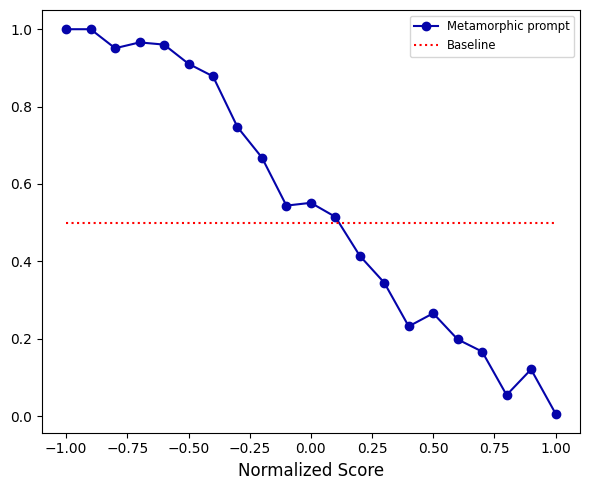

Threshold	Precision	Recall	F1-score
-0.100		0.722		0.480	0.576
-0.200		0.808		0.361	0.499
-0.300		0.873		0.267	0.409
-0.400		0.926		0.199	0.328
-0.500		0.952		0.134	0.235
-0.600		0.967		0.099	0.180
-0.700		0.971		0.064	0.120
-0.800		0.973		0.046	0.087
-0.900		1.000		0.021	0.042
-1.000		1.000		0.014	0.027


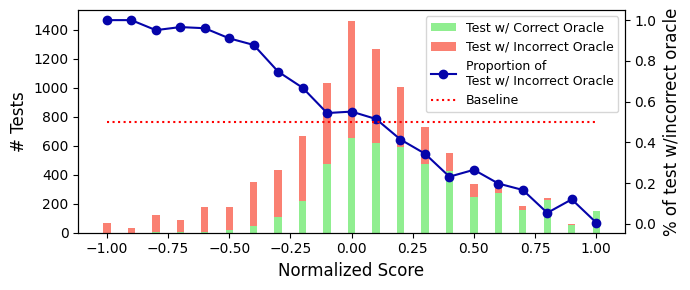

In [9]:
projects = ["Chart", "Closure", "Lang", "Math", "Time"]
#projects = ["Closure"]
total_df_8=pd.DataFrame()
for project in projects:
    with open(f'./dataframes_new/{project}_Dataframe_8_5.pkl','rb') as f:
        df_8 = pickle.load(f)
        fail_df = df_8[df_8.ground_truth == "incorrect"]
        pass_df = df_8[df_8.ground_truth == "correct"]
    total_df_8 = pd.concat([total_df_8, df_8])
fail_df = total_df_8[total_df_8.ground_truth == "incorrect"]
pass_df = total_df_8[total_df_8.ground_truth == "correct"]

#stacked_bar_metamorphic(fail_df, pass_df)
incorrect_ratio_metamorphic(fail_df, pass_df, total_df_8,"./fig/a.pdf")


from sklearn.metrics import precision_score, recall_score, f1_score
total_df_8.loc[total_df_8["ground_truth"]=="incorrect",["label"]] = 1 
total_df_8.loc[total_df_8["ground_truth"]=="correct",["label"]] = 0
normalized_score = total_df_8.score / 10
thresholds = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
def classify_with_threshold(data, threshold):
    return np.where(data <=threshold, 1, 0)
results = []
for threshold in thresholds:
    y_pred = classify_with_threshold(normalized_score, threshold)
    precision = precision_score(total_df_8.label, y_pred)
    recall = recall_score(total_df_8.label, y_pred)
    f1 = f1_score(total_df_8.label, y_pred)
    results.append((threshold, precision, recall, f1))
print("Threshold\tPrecision\tRecall\tF1-score")
for result in reversed(results):
    print(f"{result[0]:.3f}\t\t{result[1]:.3f}\t\t{result[2]:.3f}\t{result[3]:.3f}")

combined_metamorphic_analysis(fail_df, pass_df, total_df_8,"./fig/RQ1_1.pdf")

# 2. RQ2

In [55]:
projects = ["Chart", "Lang", "Math", "Closure", "Time"]

total_df_8=pd.DataFrame()
for project in projects:
    with open(f'./dataframes_new/{project}_Dataframe_8_5.pkl','rb') as f:
        df_8 = pickle.load(f)
    total_df_8 = pd.concat([total_df_8, df_8])

fail_df = total_df_8[total_df_8.ground_truth == "incorrect"]
pass_df = total_df_8[total_df_8.ground_truth == "correct"]
# Prinit out Pearson R and ratio of each prompt 
incorrect_ratio_all(fail_df, pass_df, total_df_8, "./fig/RQ2_1.pdf", figsize=(4, 2.9), markersize=4)

df_s = []
for num in [5,4,3,2,1]:
    df=pd.DataFrame()
    for project in projects:
        with open(f'./dataframes_new/{project}_Dataframe_8_{num}.pkl','rb') as f:
            project_df_8_num = pickle.load(f)
        df = pd.concat([df, project_df_8_num])
    df_s.append(df)

incorrect_ratio_self_consistency(df_s,"./fig/RQ2_2.pdf", figsize=(4, 2.9), markersize=4)

total_df_10=pd.DataFrame()
for project in projects:
    with open(f'./dataframes_new/{project}_Dataframe_10_5.pkl','rb') as f:
        df_10 = pickle.load(f)
    total_df_10 = pd.concat([total_df_10, df_10])

fail_df = total_df_10[total_df_10.ground_truth == "incorrect"]
pass_df = total_df_10[total_df_10.ground_truth == "correct"]
#incorrect_ratio_all(fail_df, pass_df, total_df_10,"./fig/two_label_ratio.pdf", figsize=(4, 2.9),markersize=4)

stacked_bar_metamorphic(fail_df, pass_df)






TypeError: incorrect_ratio_all() got an unexpected keyword argument 'markersize'

# 3. RQ3

In [6]:
def prec_recall(pred_df):
    pred_df.loc[pred_df["ground_truth"]=="incorrect",["label"]] = 1
    pred_df.loc[pred_df["ground_truth"]=="correct",["label"]] = 0
    pred_scores = -(pred_df.score_trs)
    suspiciousness = (pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
    print("len:",len(suspiciousness))
    pre, rec, th = precision_recall_curve(pred_df.label.astype(bool), suspiciousness)
    pr_auc=auc(rec, pre)
    print(f'pr_auc:{pr_auc:.4f}')

    
projects = ["Chart", "Closure", "Lang", "Math", "Time"]
total_df_8=pd.DataFrame()
for project in projects:
    with open(f'./dataframes_new/{project}_Dataframe_8_5.pkl','rb') as f:
        df_8 = pickle.load(f)
    total_df_8 = pd.concat([total_df_8, df_8])
print("assertTrue")
print(len(total_df_8[(total_df_8.type=="assertTrue") & (total_df_8.ground_truth=="incorrect")]))
print(len(total_df_8[(total_df_8.type=="assertTrue") & (total_df_8.ground_truth=="correct")]))
prec_recall(total_df_8[total_df_8.type=="assertTrue"])
print('---------------------')
print("assertFalse")
print(len(total_df_8[(total_df_8.type=="assertFalse") & (total_df_8.ground_truth=="incorrect")]))
print(len(total_df_8[(total_df_8.type=="assertFalse") & (total_df_8.ground_truth=="correct")]))
prec_recall(total_df_8[total_df_8.type=="assertFalse"])
print('---------------------')
print("assertNull")
print(len(total_df_8[(total_df_8.type=="assertNull") & (total_df_8.ground_truth=="incorrect")]))
print(len(total_df_8[(total_df_8.type=="assertNull") & (total_df_8.ground_truth=="correct")]))
prec_recall(total_df_8[total_df_8.type=="assertNull"])
print('---------------------')
print("assertNotNull")
print(len(total_df_8[(total_df_8.type=="assertNotNull") & (total_df_8.ground_truth=="incorrect")]))
print(len(total_df_8[(total_df_8.type=="assertNotNull") & (total_df_8.ground_truth=="correct")]))
prec_recall(total_df_8[total_df_8.type=="assertNotNull"])
print('---------------------')
print("assertEquals")
print(len(total_df_8[(total_df_8.type=="assertEquals") & (total_df_8.ground_truth=="incorrect")]))
print(len(total_df_8[(total_df_8.type=="assertEquals") & (total_df_8.ground_truth=="correct")]))
prec_recall(total_df_8[total_df_8.type=="assertEquals"])
print('---------------------')
print("assertNotEquals")
# print(len(total_df_8[(total_df_8.type=="assertNotEquals") & (total_df_8.ground_truth=="incorrect")]))
# print(len(total_df_8[(total_df_8.type=="assertNotEquals") & (total_df_8.ground_truth=="correct")]))
# #prec_recall(total_df_8[total_df_8.type=="assertNotEquals"])
print('---------------------')
print("assertSame")
print(len(total_df_8[(total_df_8.type=="assertSame") & (total_df_8.ground_truth=="incorrect")]))
print(len(total_df_8[(total_df_8.type=="assertSame") & (total_df_8.ground_truth=="correct")]))
prec_recall(total_df_8[total_df_8.type=="assertSame"])
print('---------------------')
print("assertNotSame")
print(len(total_df_8[(total_df_8.type=="assertNotSame") & (total_df_8.ground_truth=="incorrect")]))
print(len(total_df_8[(total_df_8.type=="assertNotSame") & (total_df_8.ground_truth=="correct")]))
prec_recall(total_df_8[total_df_8.type=="assertNotSame"])
print('---------------------')


for i in [5,4,3,2,1]:
    total_df_8=pd.DataFrame()
    for project in projects:
        with open(f'./dataframes_new/{project}_Dataframe_8_{i}.pkl','rb') as f:
            df_8 = pickle.load(f)
            print(f"{i}_{project}:") 
            prec_recall(df_8)
            print()
        total_df_8 = pd.concat([total_df_8, df_8])
    print(f"{i}_total:")
    prec_recall(total_df_8)
    print()
    print('---------------------')

assertTrue
1609
781
len: 2390
pr_auc:0.8625
---------------------
assertFalse
986
1288
len: 2274
pr_auc:0.8671
---------------------
assertNull
73
35
len: 108
pr_auc:0.8872
---------------------
assertNotNull
26
33
len: 59
pr_auc:0.7345
---------------------
assertEquals
1860
2368
len: 4228
pr_auc:0.5403
---------------------
assertNotEquals
---------------------
assertSame
178
136
len: 314
pr_auc:0.7522
---------------------
assertNotSame
9
100
len: 109
pr_auc:0.2039
---------------------
5_Chart:
len: 5368
pr_auc:0.7925

5_Closure:
len: 186
pr_auc:0.5470

5_Lang:
len: 1188
pr_auc:0.8108

5_Math:
len: 1480
pr_auc:0.5914

5_Time:
len: 1260
pr_auc:0.6843

5_total:
len: 9482
pr_auc:0.7549

---------------------
4_Chart:
len: 5368
pr_auc:0.7863

4_Closure:
len: 186
pr_auc:0.5403

4_Lang:
len: 1188
pr_auc:0.8038

4_Math:
len: 1480
pr_auc:0.5909

4_Time:
len: 1260
pr_auc:0.6728

4_total:
len: 9482
pr_auc:0.7483

---------------------
3_Chart:
len: 5368
pr_auc:0.7764

3_Closure:
len: 186
pr_

# RQ4

In [7]:
projects = ["Chart", "Closure", "Lang", "Math", "Time"]
total_df_8 = pd.DataFrame()
for project in projects:
    with open(f'./dataframes_new/{project}_Dataframe_8_5.pkl','rb') as f:
        df_8 = pickle.load(f)
    total_df_8 = pd.concat([total_df_8, df_8])
display(total_df_8[(total_df_8.score >= 8) & (total_df_8.ground_truth =="incorrect")])
a = total_df_8[(total_df_8.score >= 8) & (total_df_8.ground_truth =="incorrect")]
with open('../query/gpt4_tests.txt',"w") as f:
    for idx, row in a.iterrows():
        print(f'{row.project} {row.idx} {row.test_no}\n')
        f.write(f'{row.project} {row.idx} {row.test_no}\n')
print(len(total_df_8[(total_df_8.score >= 8) & (total_df_8.ground_truth =="incorrect")]))

,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
375,Chart,1,2251,newTS_300,test1,org.jfree.chart.imagemap,assertEquals,44,incorrect,"[correct, correct, correct, correct, correct]","[incorrect, incorrect, undecidable, incorrect,...",5,4,9
953,Chart,1,1938,newTS_300,test22,org.jfree.chart.axis,assertEquals,94,incorrect,"[correct, correct, correct, correct, correct]","[incorrect, undecidable, incorrect, incorrect,...",5,4,9
1722,Chart,1,10323,newTS_300,test8,org.jfree.data.time,assertFalse,50,incorrect,"[incorrect, correct, correct, correct, correct]","[incorrect, incorrect, incorrect, incorrect, i...",3,5,8
49,Lang,1,3097,newTS_300,test3,org.apache.commons.lang3.math,assertEquals,56,incorrect,"[correct, correct, correct, correct, correct]","[undecidable, incorrect, incorrect, incorrect,...",5,4,9
51,Lang,1,3160,newTS_300,test1,org.apache.commons.lang3.math,assertEquals,56,incorrect,"[correct, correct, correct, correct, correct]","[incorrect, undecidable, undecidable, incorrec...",5,3,8
96,Lang,1,3631,newTS_300,test1,org.apache.commons.lang3,assertEquals,87,incorrect,"[correct, incorrect, correct, correct, correct]","[incorrect, incorrect, incorrect, incorrect, i...",3,5,8
103,Lang,1,3521,newTS_300,test1,org.apache.commons.lang3,assertEquals,87,incorrect,"[correct, correct, correct, correct, correct]","[incorrect, undecidable, incorrect, incorrect,...",5,4,9
356,Lang,1,1545,newTS_300,test3,org.apache.commons.lang3.math,assertEquals,81,incorrect,"[correct, correct, correct, correct, correct]","[correct, incorrect, incorrect, incorrect, inc...",5,3,8
400,Lang,1,2406,newTS_300,test9,org.apache.commons.lang3.text,assertTrue,46,incorrect,"[correct, correct, correct, correct, correct]","[incorrect, incorrect, incorrect, incorrect, i...",5,5,10
501,Lang,1,4224,newTS_300,test0,org.apache.commons.lang3.reflect,assertNotSame,115,incorrect,"[correct, correct, correct, correct, undecidable]","[incorrect, incorrect, incorrect, incorrect, i...",4,5,9


Chart 2251 test1

Chart 1938 test22

Chart 10323 test8

Lang 3097 test3

Lang 3160 test1

Lang 3631 test1

Lang 3521 test1

Lang 1545 test3

Lang 2406 test9

Lang 4224 test0

Lang 4229 test3

Math 1144 test1

Math 8658 test4

Math 10485 test2

Math 10501 test5

Math 10504 test2

Math 10503 test2

Math 3296 test1

Math 3201 test3

Math 58 test1

Time 1392 test0

21


### 2. Document Length

In [8]:
# projects = ["Chart", "Closure", "Lang", "Math", "Time"]
# total_df_8 = pd.DataFrame()
# for project in projects:
#     with open(f'{project}_Dataframe_8_5_DOC.pkl','rb') as f:
#         df_8 = pickle.load(f)
#         print(project)
#         print(df_8.document_length.mean())
#         print('-------------------------')

#     total_df_8 = pd.concat([total_df_8, df_8])
#     score_doclen = {}
#     for score in range(0, 11):
#         abs_score_df = df_8[(df_8.score == score) | (df_8.score == -score)]
#         print('프로젝트:', project, '점수', score, '갯수:', len(abs_score_df))        
#         if not abs_score_df.empty:
#             score_doclen[score] =  abs_score_df.document_length.mean()
#     score_doclen_df = pd.DataFrame(list(score_doclen.items()),columns=["score","length"])
#     print("doc_pearsonr:",pearsonr(score_doclen_df["length"], score_doclen_df["score"]))
#     print(f"{project}")
#     print(score_doclen.keys())
#     a= map(lambda x : round(x,2), score_doclen.values())
#     print(list(a))
#     plt.plot(score_doclen.keys(), score_doclen.values(), marker=".", label=f"{project}")
    
# plt.title("Correlation Btw Document_length And Scrore")
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()
# display(total_df_8[(total_df_8.type =="assertNotSame") & (total_df_8.ground_truth =="incorrect")])


# score_doclen = {}
# for score in range(0, 11):
#     abs_score_df = total_df_8[(total_df_8.score == score) | (total_df_8.score == -score)]
#     print('갯수:',len(abs_score_df),'점수',score) 
#     if not abs_score_df.empty:
#         score_doclen[score] =  abs_score_df.document_length.mean()
# score_doclen_df = pd.DataFrame(list(score_doclen.items()),columns=["score","length"])
# print("doc_pearsonr:",pearsonr(score_doclen_df["length"], score_doclen_df["score"]))
# print(score_doclen.keys())
# a= map(lambda x : round(x,2), score_doclen.values())
# print(list(a))
# plt.plot(score_doclen.keys(), score_doclen.values(), marker=".", label=f"Total")

# plt.title("Correlation Btw Document_length And Scrore")
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()
    


### 3. Classifier

### 1) k-fold validation

In [9]:

projects = ["Chart", "Lang", "Math", "Closure", "Time"]

total_df_8=pd.DataFrame()
for project in projects:
    with open(f'./dataframes_new/{project}_Dataframe_8_5.pkl','rb') as f:
        df_8 = pickle.load(f)
    total_df_8 = pd.concat([total_df_8, df_8])
total_df_8.loc[total_df_8["ground_truth"]=="incorrect",["label"]] = 1 
total_df_8.loc[total_df_8["ground_truth"]=="correct",["label"]] = 0

def count_occurrences(attempt_list, label):
    return attempt_list.count(label)

labels = ["correct", "undecidable", "incorrect"]
for label in labels:
    total_df_8[f"attempt_org_{label}_cnt"] = total_df_8["attempt_org"].apply(lambda x: count_occurrences(x, label))
    total_df_8[f"attempt_trs_{label}_cnt"] = total_df_8["attempt_trs"].apply(lambda x: count_occurrences(x, label))

from sklearn.model_selection import KFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc
# Prepare the entire dataset for cross-validation, no initial train/test split needed
X = total_df_8[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]]
y = total_df_8["label"]

# Initialize the KFold class
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Adjust n_splits based on your preference

# Lists to store results of each fold
precisions = []
recalls = []
pr_aucs = []

for train_index, test_index in kf.split(X):
    # Split data into training and test for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale features
    scaler = MaxAbsScaler()
    s_X_train = scaler.fit_transform(X_train)
    s_X_test = scaler.transform(X_test)

    # Train model
    model = LogisticRegression(class_weight="balanced")
    model.fit(s_X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(s_X_test)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

    # Calculate precision-recall curve and AUC for each fold
    y_scores = model.predict_proba(s_X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    pr_aucs.append(auc(recall, precision))

# Calculate average of each metric across all folds
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average Precision-Recall AUC: {np.mean(pr_aucs)}")


Average Precision: 0.7061050996209476
Average Recall: 0.7141710547572139
Average Precision-Recall AUC: 0.7929100654502894


### 2) Comparison with Score_based


0.5002635740643121
Precision: 0.7182203389830508
Recall: 0.7144362486828241
Precision-Recall AUC_Logistic Regression: 0.8015163889672976


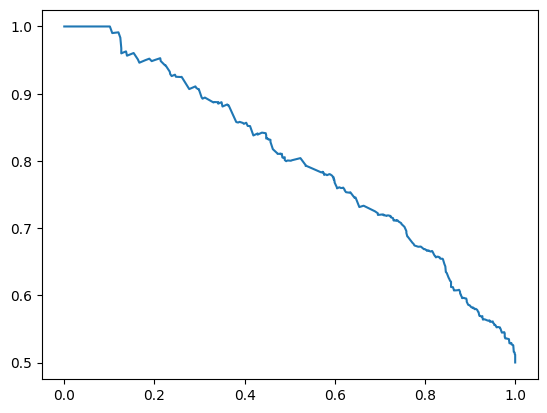

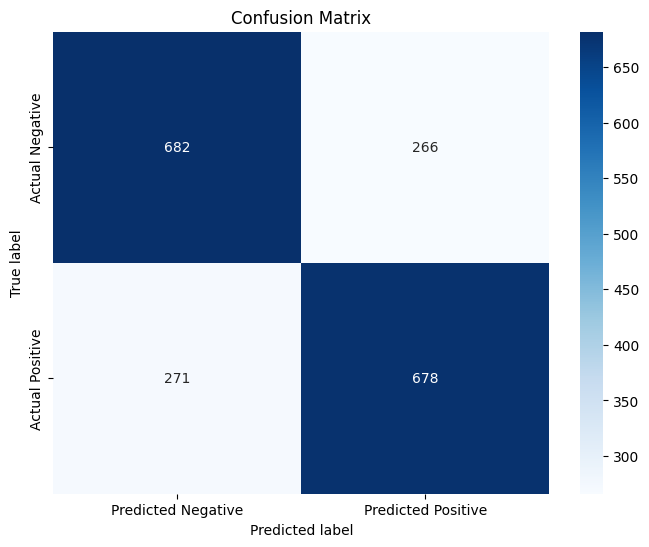

Precision-Recall AUC_Logistic Regression: 0.8015163889672976


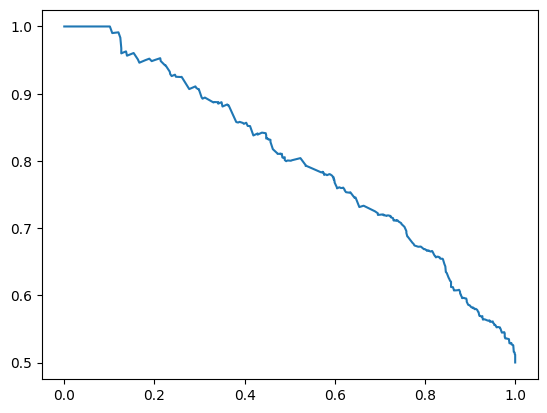

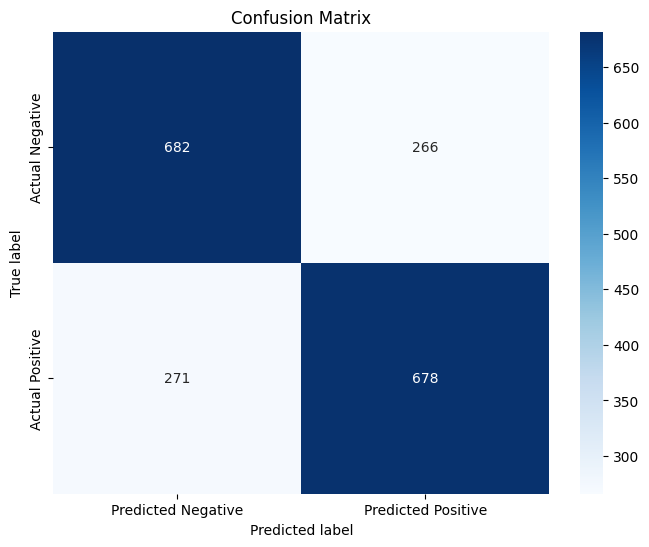

Precision-Recall AUC_Logistic Regression: 0.8015163889672976


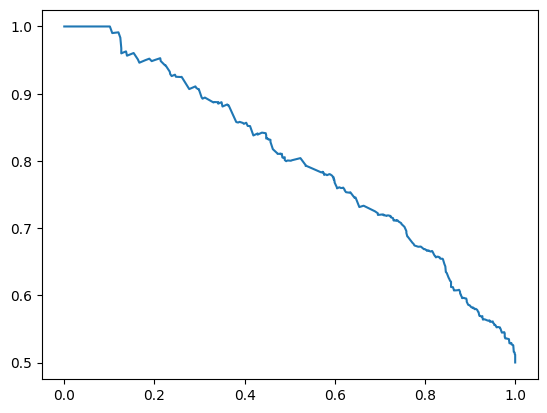

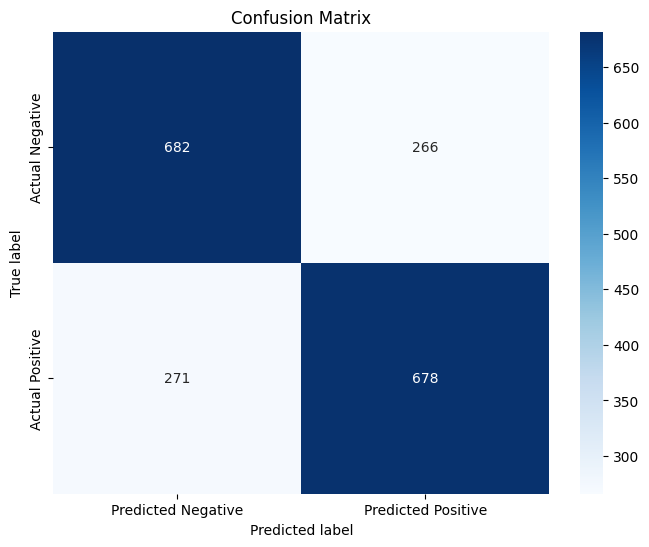

Precision-Recall AUC_Logistic Regression: 0.8015163889672976


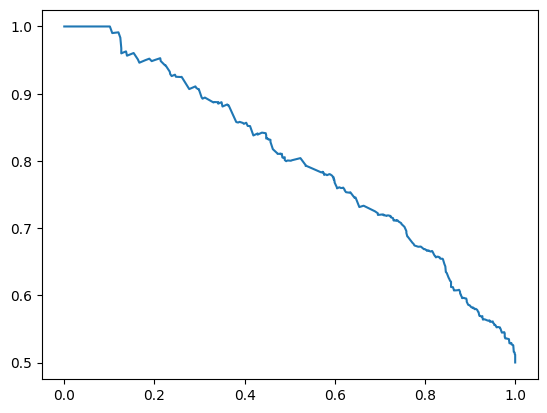

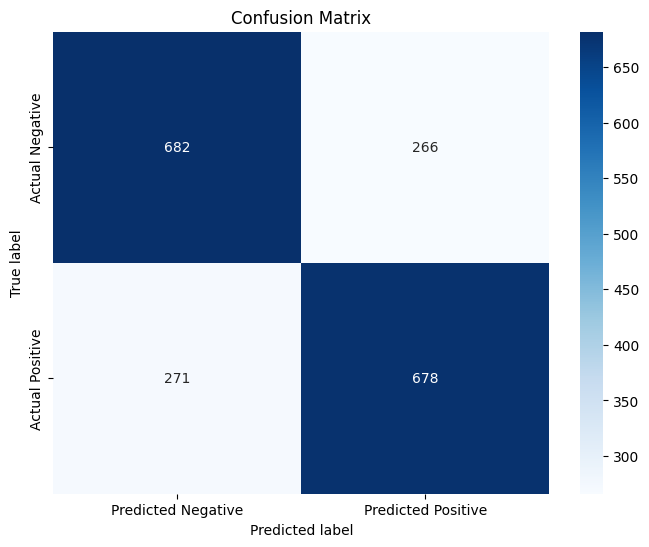

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(total_df_8[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]], total_df_8["label"], test_size=0.20, stratify=total_df_8["label"])
scaler = MaxAbsScaler()
s_X_train = scaler.fit_transform(X_train)
model = LogisticRegression(class_weight="balanced")
model.fit(s_X_train,y_train)

s_X_test = scaler.transform(X_test)
y_pred = model.predict(s_X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# For precision-recall curve and AUC, you need probability scores
print(y_test.mean())
print(f"Precision: {precision}")
print(f"Recall: {recall}")
y_scores = model.predict_proba(s_X_test)[:, 1]  
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC_Logistic Regression: {pr_auc}")
plt.plot(recall, precision, label = 'Logistic Regression')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


# #For Score_Based
# X_test["score_org"] = X_test.attempt_org_correct_cnt - X_test.attempt_org_incorrect_cnt
# X_test["score_trs"] = X_test.attempt_trs_incorrect_cnt - X_test.attempt_trs_correct_cnt
# pred_scores = X_test.score_org  + X_test.score_trs
# suspiciousness = -(pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
# prec, rec, thresholds = precision_recall_curve(y_test.astype(bool), suspiciousness)
# # print(thresholds)
# # print(auc(rec, prec))
# plt.plot(rec, prec, label = "Score based")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title("Precision-Recall Curve")
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC_Logistic Regression: {pr_auc}")
plt.plot(recall, precision, label = 'Logistic Regression')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


# #For Score_Based
# X_test["score_org"] = X_test.attempt_org_correct_cnt - X_test.attempt_org_incorrect_cnt
# X_test["score_trs"] = X_test.attempt_trs_incorrect_cnt - X_test.attempt_trs_correct_cnt
# pred_scores = X_test.score_org  + X_test.score_trs
# suspiciousness = -(pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
# prec, rec, thresholds = precision_recall_curve(y_test.astype(bool), suspiciousness)
# # print(thresholds)
# # print(auc(rec, prec))
# plt.plot(rec, prec, label = "Score based")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title("Precision-Recall Curve")
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC_Logistic Regression: {pr_auc}")
plt.plot(recall, precision, label = 'Logistic Regression')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


# #For Score_Based
# X_test["score_org"] = X_test.attempt_org_correct_cnt - X_test.attempt_org_incorrect_cnt
# X_test["score_trs"] = X_test.attempt_trs_incorrect_cnt - X_test.attempt_trs_correct_cnt
# pred_scores = X_test.score_org  + X_test.score_trs
# suspiciousness = -(pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
# prec, rec, thresholds = precision_recall_curve(y_test.astype(bool), suspiciousness)
# # print(thresholds)
# # print(auc(rec, prec))
# plt.plot(rec, prec, label = "Score based")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title("Precision-Recall Curve")
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC_Logistic Regression: {pr_auc}")
plt.plot(recall, precision, label = 'Logistic Regression')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


# #For Score_Based
# X_test["score_org"] = X_test.attempt_org_correct_cnt - X_test.attempt_org_incorrect_cnt
# X_test["score_trs"] = X_test.attempt_trs_incorrect_cnt - X_test.attempt_trs_correct_cnt
# pred_scores = X_test.score_org  + X_test.score_trs
# suspiciousness = -(pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
# prec, rec, thresholds = precision_recall_curve(y_test.astype(bool), suspiciousness)
# # print(thresholds)
# # print(auc(rec, prec))
# plt.plot(rec, prec, label = "Score based")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title("Precision-Recall Curve")

### 3. Cross project

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_curve
from itertools import combinations_with_replacement,product

def count_occurrences(attempt_list, label):
    return attempt_list.count(label)

projects =["Chart", "Closure", "Lang", "Math", "Time"]
projects ={"Chart":("Closure", "Lang", "Math","Time"), "Closure":("Chart", "Lang", "Math","Time"), "Lang":("Chart", "Closure", "Math","Time"), "Math":("Chart", "Closure", "Lang","Time"),"Time":("Chart", "Closure", "Lang", "Math")}

for train_project, test_projects in projects.items():
    with open(f"./dataframes_new/{train_project}_Dataframe_8_5.pkl","rb") as f:
        train_df = pickle.load(f)
    
    test_df = pd.DataFrame()
    for project in test_projects:
        with open(f"./dataframes_new/{project}_Dataframe_8_5.pkl","rb") as f:
            test_df_tmp = pickle.load(f)
            test_df = pd.concat([test_df, df_8])

    train_df.loc[train_df["ground_truth"]=="incorrect",["label"]] = 1 
    train_df.loc[train_df["ground_truth"]=="correct",["label"]] = 0
    test_df.loc[test_df["ground_truth"]=="incorrect",["label"]] = 1 
    test_df.loc[test_df["ground_truth"]=="correct",["label"]] = 0

    labels = ["correct", "undecidable", "incorrect"]
    for label in labels:
        train_df[f"attempt_org_{label}_cnt"] = train_df["attempt_org"].apply(lambda x: count_occurrences(x, label))
        train_df[f"attempt_trs_{label}_cnt"] = train_df["attempt_trs"].apply(lambda x: count_occurrences(x, label))
        test_df[f"attempt_org_{label}_cnt"] = test_df["attempt_org"].apply(lambda x: count_occurrences(x, label))
        test_df[f"attempt_trs_{label}_cnt"] = test_df["attempt_trs"].apply(lambda x: count_occurrences(x, label))

    # Train model with train_df
    print(f"Train Regression model with {train_project}")
    X_train, X_test, y_train, y_test = train_test_split(train_df[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]], train_df["label"], test_size=0.20, stratify=train_df["label"])
    scaler = MaxAbsScaler()
    s_X_train = scaler.fit_transform(X_train)
    model = LogisticRegression(class_weight="balanced")
    model.fit(s_X_train,y_train)

    # Test model with test_df
    X_Test_DF = test_df[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]]
    s_X_TEST_DF = scaler.transform(X_Test_DF)
    y_pred_chart = model.predict(s_X_TEST_DF)

    # Evaluate model performance on chart_df_8
    true_labels_chart = test_df["label"]
    precision = precision_score(true_labels_chart, y_pred_chart)
    recall = recall_score(true_labels_chart, y_pred_chart)
    f1 = f1_score(true_labels_chart, y_pred_chart)
    print(f"Precision on {test_project}: {precision:.4f}")
    print(f"Recall on {test_project}: {recall:.4f}")
    print(f"F1 Score on {train_project}: {f1:.4f}")

    precision, recall, thresholds = precision_recall_curve(true_labels_chart, model.predict_proba(s_X_TEST_DF)[:,1])
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC_Logistic Regression: {pr_auc:.4f}")
    print()
    print()

# # For precision-recall curve and AUC, you need probability scores
# print(y_test.mean())
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# y_scores = model.predict_proba(s_X_test)[:, 1]  
# precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
# pr_auc = auc(recall, precision)
# print(f"Precision-Recall AUC_Logistic Regression: {pr_auc}")
# plt.plot(recall, precision, label = 'Logistic Regression')


# X_chart = chart_df_8[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]]

# # Scaling `X_chart` using the same scaler object used for `X_train`
# # Important: Use .transform(), NOT .fit_transform()
# s_X_chart = scaler.transform(X_chart)

# # Predicting on `chart_df_8` using the trained model
# y_pred_chart = model.predict(s_X_chart)

# # If `chart_df_8` has a 'label' column for true labels, you can calculate performance metrics
# if 'label' in chart_df_8.columns:
#     true_labels_chart = chart_df_8["label"]
#     precision_chart = precision_score(true_labels_chart, y_pred_chart)
#     recall_chart = recall_score(true_labels_chart, y_pred_chart)

#     # Outputting precision and recall for `chart_df_8`
#     print(f"Precision on chart_df_8: {precision_chart}")
#     print(f"Recall on chart_df_8: {recall_chart}")


Train Regression model with Chart


NameError: name 'test_project' is not defined